# Exercise M4.04

In this exercise, we will train an l2-penalized logistic regression classifier and investigate the effect of the parameter `c`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
penguins = pd.read_csv('data/penguins_classification.csv')
# only keep the Adelie and Chinstrap classes
penguins = penguins.set_index('Species').loc[['Adelie', 'Chinstrap']].reset_index()

In [4]:
penguins.sample(3)

,Species,Culmen Length (mm),Culmen Depth (mm)
94,Adelie,40.8,18.9
178,Chinstrap,49.5,19.0
103,Adelie,37.9,18.6


In [5]:
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

In [7]:
from sklearn.model_selection import train_test_split

penguins_data, penguins_test = train_test_split(penguins, random_state=0)

data_train = penguins_data[culmen_columns]
data_test = penguins_test[culmen_columns]

target_train = penguins_data[target_column]
target_test = penguins_test[target_column]

range_features = {
    feature_name: (penguins[feature_name].min() - 1,
                   penguins[feature_name].max() + 1)
    for feature_name in culmen_columns
}

In [8]:
range_features

{'Culmen Length (mm)': (31.1, 59.0), 'Culmen Depth (mm)': (14.5, 22.5)}

Helper plot function:

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu_r")
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])

    return ax

First, let's create our predictive model:

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [11]:
logistic_regression = make_pipeline(StandardScaler(),
                                   LogisticRegression(penalty='l2'))

Given the following candidates for the `C` parameter, we want to find out the impact of `C` on the classifier decision boundary.

In [23]:
Cs = [0.01, 0.1, 1, 10]

In [13]:
logistic_regression.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

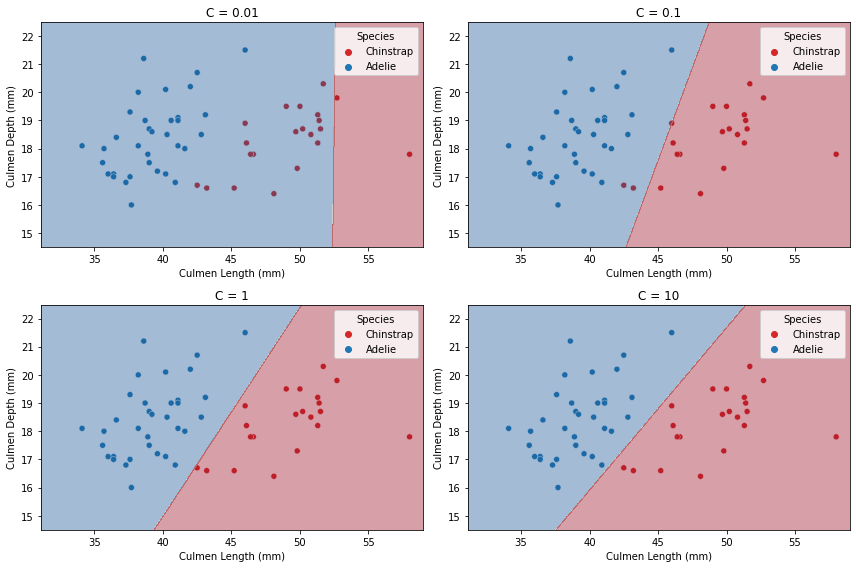

In [26]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
a = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i, c in enumerate(Cs):
    logistic_regression.set_params(logisticregression__C=c)
    logistic_regression.fit(data_train, target_train)
    sns.scatterplot( ax=ax[a[i]],
    data=penguins_test, x=culmen_columns[0], y=culmen_columns[1],
    hue=target_column, palette=["tab:red", "tab:blue"])
    ax[a[i]].set_title(f'C = {c}')
    plot_decision_function(logistic_regression, range_features, ax=ax[a[i]]);
plt.tight_layout()

Let's take a look at the impact of `C` hyperparameter on the magnitude of the weights

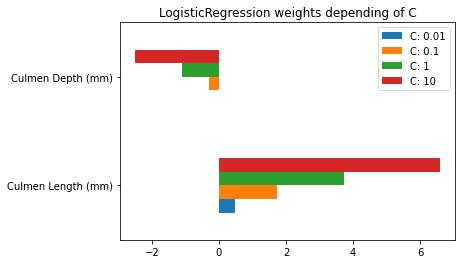

In [27]:
# solution
weights_ridge = []
for C in Cs:
    logistic_regression.set_params(logisticregression__C=C)
    logistic_regression.fit(data_train, target_train)
    coefs = logistic_regression[-1].coef_[0]
    weights_ridge.append(pd.Series(coefs, index=culmen_columns))
    
weights_ridge = pd.concat(
    weights_ridge, axis=1, keys=[f"C: {C}" for C in Cs])
weights_ridge.plot.barh()
_ = plt.title("LogisticRegression weights depending of C")

We see that a small  `C` will shrink the weights value toward zero. It means that a small `C` provides a more regularized model.  
Thus, `C` is the inverse of the `alpha` coefficient in the `Ridge` model.

Besides, with a strong penalty (i.e. small C value), the weight of the feature `"Culmen Depth (mm)"` is almost zero. It explains why the decision separation in the plot is almost perpendicular to the `"Culmen Length (mm)"` feature.